In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input


# Gasoline RBOB

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('Gasoline RBOB Futures Historical Data.csv').dropna()

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])



In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,2.6847,2.6878,2.6976,2.6877,0.15K,-0.59%
1,2024-03-26,2.7006,2.7489,2.7500,2.6980,0.39K,-1.74%
2,2024-03-25,2.7484,2.7370,2.7603,2.7310,0.62K,1.11%
4,2024-03-22,2.7398,2.7090,2.7456,2.7090,0.61K,0.47%
5,2024-03-21,2.7271,2.7370,2.7376,2.7119,0.15K,-0.22%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,1.4150,1.3136,1.3790,1.2685,87520,7.81
1,2019-01-03,1.4377,1.3160,1.3676,1.3016,57750,1.60
2,2019-01-04,1.4515,1.3364,1.3981,1.3293,66360,0.96
3,2019-01-07,1.4505,1.3560,1.3945,1.3389,79090,5.95
4,2019-01-08,1.4740,1.3466,1.3722,1.3385,74920,1.62
...,...,...,...,...,...,...,...
1325,2024-03-21,2.7271,2.7370,2.7376,2.7119,150,-0.22
1326,2024-03-22,2.7398,2.7090,2.7456,2.7090,610,0.47
1327,2024-03-25,2.7484,2.7370,2.7603,2.7310,620,1.11
1328,2024-03-26,2.7006,2.7489,2.7500,2.6980,390,-1.74


In [7]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [9]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [10]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])



In [11]:
# 10. Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0485
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0068
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0014
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.9959e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.6038e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.5345e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.6795e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


In [14]:


# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.11905724772019656
MAPE trên tập test là: 3.8938433139053914 %
MAE trên tập test là: 0.09757817809998034


In [15]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [16]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.625584
1331,2.607038
1332,2.584176
1333,2.559927
1334,2.535927
1335,2.512763
1336,2.490731
1337,2.469884
1338,2.449946
1339,2.430891


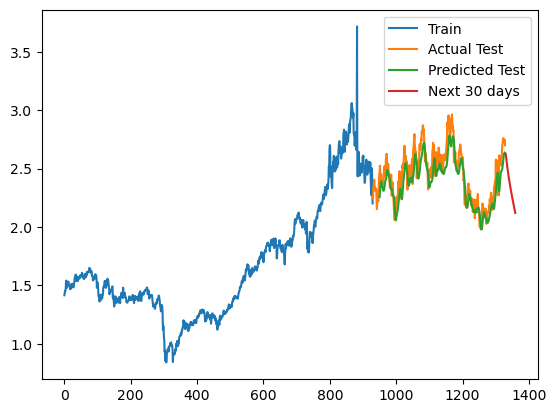

In [17]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('LSTM_Gasoline_RBOB_73.png') 
plt.show()


## 8:2

In [18]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [19]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back -1):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [20]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0437
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.9219e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [22]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


In [23]:


# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.08832596530859413
MAPE trên tập test là: 2.8396050506160275 %
MAE trên tập test là: 0.06843206641372371


In [24]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [25]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.718928
1331,2.718445
1332,2.725474
1333,2.735992
1334,2.747927
1335,2.760062
1336,2.771755
1337,2.782597
1338,2.792221
1339,2.800616


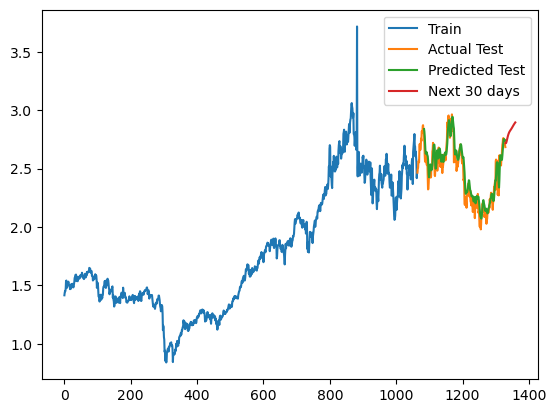

In [26]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

### 9:1

In [27]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [28]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [29]:
# 10. Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0724
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0061
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - lo

In [31]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step


In [32]:



# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07370063586235388
MAPE trên tập test là: 2.3432878218368445 %
MAE trên tập test là: 0.054496089492525324


In [33]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

In [34]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.657246
1331,2.636721
1332,2.617743
1333,2.601207
1334,2.587012
1335,2.574825
1336,2.564130
1337,2.554399
1338,2.545279
1339,2.536398


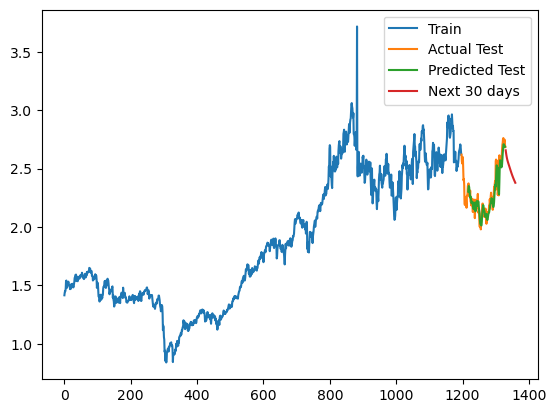

In [35]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()